<a href="https://colab.research.google.com/github/YachaySCG/summer_school_2021/blob/master/template_pytorch_sc_2021.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project Template

This is a project template for the challenge SC 2021

## Setup

In [ ]:
!pip -q install gdown

In [ ]:
import os
import torch
import numpy as np

import torchvision
import torchvision.transforms as transforms
import multiprocessing
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import datetime
import csv
import pandas as pd
from torch.autograd import Variable
from torch.utils.data import Dataset
from PIL import Image

In [ ]:
CONNECT_GDRIVE = False

if CONNECT_GDRIVE:
    from google.colab import drive
    drive.mount('/content/gdrive')
    if not os.path.exists("/content/gdrive/MyDrive/summer_school_2021"):
        os.path.makedirs("/content/gdrive/MyDrive/summer_school_2021")
    
    %cd /content/gdrive/MyDrive/summer_school_2021

Mounted at /content/gdrive
/content/gdrive/MyDrive/summer_school_2021


In [ ]:
# Create folders and set cuda available
use_cuda = torch.cuda.is_available()

RESULT_DIR = './stuff/results/'
CHECKPOINTS_DIR = 'stuff/checkpoints/'
if not os.path.exists(RESULT_DIR):
    os.makedirs(RESULT_DIR)

if not os.path.isdir(CHECKPOINTS_DIR):
      os.mkdir(CHECKPOINTS_DIR)

##  Set random seed

 Executing `set_seed(seed=seed)` you are setting the seed

In [ ]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')

# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

##  Set device (GPU or CPU)


In [ ]:
# @title Set device (GPU or CPU)

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

### Random seeds

If you want to obtain reproducible results, it is a good practice to set seeds for the random number generators of the various libraries

In [ ]:
set_seed(seed=2021)
device = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


---
# Data

## Source dataset

We will train the model using a modief version of Intel Classification Image dataset from [Kaggle](https://www.kaggle.com/puneet6060/intel-image-classification), but with small tweaks we can get any other data we are interested in. The dataset is composed of image of 6 classes: `buildings`, `forest`, `glacier`, `mountain`, `sea`, `street`.

Note that the data set is normalised by substracted the mean and dividing by the standard deviation (pre-computed) of the training set. Also, if `AUGMENTATION` is `True`, data augmentation will be applied during training.

In [ ]:
#@title Download and uncompress the dataset

if not os.path.exists("stuff/data"):
    os.makedirs("stuff/data")

!gdown https://drive.google.com/uc?id=1pFWcrh9Qdn8irqognubPTjfaY1uDecFM
!unzip -qq dataset_sc_2021.zip
!mv test stuff/data/
!mv val stuff/data/
!mv train stuff/data/

Downloading...
From: https://drive.google.com/uc?id=1pFWcrh9Qdn8irqognubPTjfaY1uDecFM
To: /content/gdrive/My Drive/summer_school_2021/dataset_sc_2021.zip
116MB [00:00, 134MB/s]


Prepare de Data

In [ ]:
AUGMENTATION = False  # True/False if you want use torchvision augmentations
IMG_SIZE = (150,150)

print('==> Preparing data..')

# ImageNet normalizing
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

# torchvision transforms
transform_train = transforms.Compose([])
if AUGMENTATION:
  transform_train.transforms.append(transforms.RandomHorizontalFlip(p=0.30))
  transform_train.transforms.append(transforms.RandomRotation(degrees=30))

transform_train.transforms.append(transforms.Resize(IMG_SIZE))
transform_train.transforms.append(transforms.ToTensor())
transform_train.transforms.append(transforms.Normalize(mean, std))

transform_test = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

trainset = torchvision.datasets.ImageFolder(
  root= 'stuff/data/train', transform=transform_train)

valset = torchvision.datasets.ImageFolder(
  root='stuff/data/val', transform=transform_test)

==> Preparing data..


 Check the size of the datasets and classes

In [ ]:
# print the size of dataset
print("Train images: ", len(trainset))
print("Val images: ", len(valset))
classes_names = trainset.classes
print(classes_names)

Train images:  9300
Val images:  3000
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


## Data loaders

A dataloader is an optimized data iterator that provides functionality for efficient shuffling, transformation and batching of the data.

###  Dataloader


In [ ]:
# Dataloader

BATCH_SIZE = 128
num_workers = multiprocessing.cpu_count()

print(f'----> number of workers: {num_workers}')

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=num_workers)
valloader = torch.utils.data.DataLoader(
    valset, batch_size=BATCH_SIZE, shuffle=False, num_workers=num_workers)

----> number of workers: 2


# Displaying Data

In [ ]:
# @title Plotting functions

class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

def imshow(img):
  plt.figure(figsize=[20, 20])
  #unnormalize
  #img = img * torch.tensor(std).unsqueeze(dim=-1).unsqueeze(dim=-1)
  #img = img + torch.tensor(mean).unsqueeze(dim=-1).unsqueeze(dim=-1)
  img = UnNormalize(mean,std)(img)
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis(False)
  plt.show()

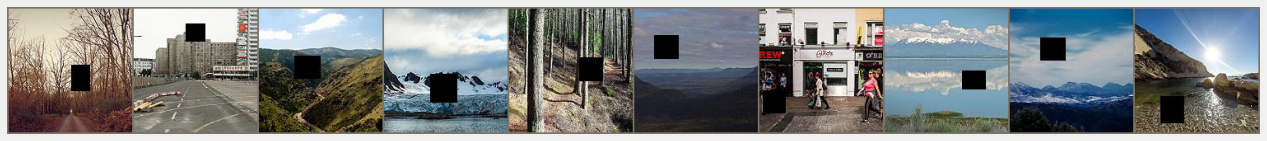

In [ ]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images[:10], nrow = 10))

# Define a model


In [ ]:
# TODO: Define a model for training
class MyModel(nn.Module):
    def __init__(self, ):
        super(MyModel, self).__init__()
        # TODO: Define the initialization step
        ...
                    
    def forward(self, x):
        # TODO: define the forward pass
        return ...

model = MyModel()

## Training the model

In [ ]:
# TODO: Define the main functions for training and the main loop

### Plotting results

In [ ]:
#@title Util Functions

def plot_results(results, name):
  """
    results: pandas DataFrame with the following fields

        - epoch : number of epoch
        - train acc : value of the train accuracy at each epoch 
        - test acc : value of the test accuracy at each epoch 
        - train loss : value of the train loss at each epoch 
        - test loss : value of the test loss at each epoch 

    name: name to save the image result
  """
  train_accuracy = results['train acc'].values
  test_accuracy = results['test acc'].values

  train_loss = results['train loss'].values
  test_loss = results['test loss'].values

  figureName = name +"_results" # change figure name

  plt.style.use('fivethirtyeight')
  fig, (ax1, ax2) = plt.subplots(figsize=(16,8),nrows=1, ncols=2, sharex=True, sharey=False)
  ax1.plot(results['epoch'].values, train_accuracy, label='train', color='r', marker='s', lw=3)
  ax1.plot(results['epoch'].values, test_accuracy, label='test', color='b', marker='o', lw=3)
  ax1.legend()
  ax1.set_ylim([0,100])
  ax1.set(xlabel="Epochs", ylabel="Accuracy Score")
  ax2.plot(results['epoch'].values, train_loss, label='train', color='r', marker='s', lw=3)
  ax2.plot(results['epoch'].values, test_loss, label='test', color='b', marker='o', lw=3)
  ax2.legend()
  ax2.set(xlabel="Epochs", ylabel="Loss")
  fig.savefig(os.path.join(RESULT_DIR,f'{figureName}.png'))
  plt.show()


In [ ]:
!ls $RESULT_DIR

log_2021_09_06-17:33:42.csv  log_2021_09_06-18:46:44.csv
log_2021_09_06-17:33:54.csv  log_2021_09_06-18:48:41.csv
log_2021_09_06-18:43:25.csv


In [ ]:
# the plot_results function expects a data frame results and the name to save the file
# the fields of the data frame are

# - epoch : number of epoch
# - train acc : value of the train accuracy at each epoch 
# - test acc : value of the test accuracy at each epoch 
# - train loss : value of the train loss at each epoch 
# - test loss : value of the test loss at each epoch 

# loading results from previous saved .csv
name = "log_2021_09_06-17:33:54.csv"
results = pd.read_csv(os.path.join(RESULT_DIR,name), sep =',')
results

,epoch,train loss,train acc,test loss,test acc
0,0,1.786445,19.817204,1.746265,24.533333
1,1,1.612399,31.505377,1.475642,50.433334
2,2,1.324263,45.537636,1.026476,73.099998
3,3,0.966855,62.698925,0.620457,85.033333
4,4,0.667306,76.903229,0.424994,86.500000
5,5,0.525791,81.731186,0.374785,87.500000
6,6,0.466714,84.279572,0.343929,88.766670
7,7,0.416359,85.838707,0.329858,89.300003
8,8,0.384126,86.913979,0.321522,89.466667


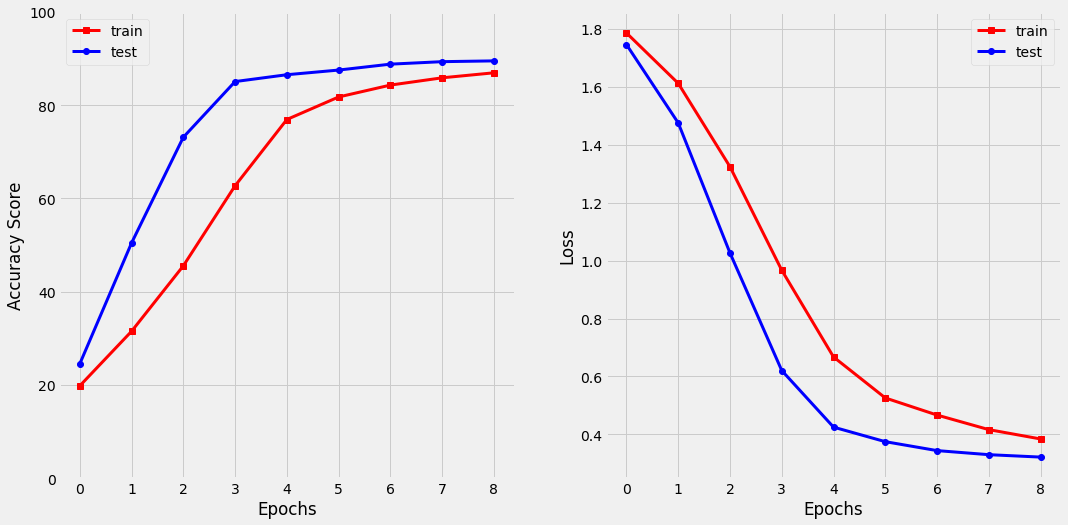

In [ ]:
# plotting results
plot_results(results, name.split(".")[0])

### Saving Model Evaluation File

In [ ]:
# TODO: Load the weights to the model
checkpoint_path = os.path.join(CHECKPOINTS_DIR, ... )

load_model = torch.load()

In [ ]:
#@title Custom Dataset to load the test subset

class CustomDataSet(Dataset):
    def __init__(self, main_dir, transform):
        self.main_dir = main_dir
        self.transform = transform
        all_imgs = os.listdir(main_dir)
        self.total_imgs = sorted(all_imgs)

    def __len__(self):
        return len(self.total_imgs)

    def __getitem__(self, idx):
        img_loc = os.path.join(self.main_dir, self.total_imgs[idx])
        image = Image.open(img_loc).convert("RGB")
        tensor_image = self.transform(image)
        return self.total_imgs[idx], tensor_image

In [ ]:
# Load test data
IMG_SIZE = (150,150)

# ImageNet normalizing
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform_test = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

test_set = CustomDataSet(main_dir='stuff/data/test', transform=transform_test)
test_loader = torch.utils.data.DataLoader(test_set , 
                                          batch_size=1, 
                                          shuffle=False, 
                                          num_workers=num_workers)

In [ ]:
print("Test images: ", len(test_set))

Test images:  4734


In [ ]:
classes_names

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']

In [ ]:
# labels to write in the .csv file
labels_csv = ['B', 'F', 'G', 'M','S', 'ST']
labels_csv

['B', 'F', 'G', 'M', 'S', 'ST']

In [ ]:
# Saving the image id and prediction in a .csv file
logname = os.path.join(RESULT_DIR,'sample_submission_first_n.csv')

if not os.path.exists(""):
  with open(logname, 'w') as logfile:
    logwriter = csv.writer(logfile, delimiter=',')
    logwriter.writerow(['id', 'label'])

for idx, (img_id, img) in enumerate(test_loader):

  
  # TODO: Check what is the result of load_model
  # If the y_pred is the index, which corresponds to an specific class
  # This implementation will not have mistakes.
  # Otherwise, you probably need to add a torch.argmax layer after y_pred

  y_pred = load_model(img.cuda())
  y_pred = torch.argmax(y_pred)
  y_pred = y_pred.cpu().item()
  #print(img_id[0].split(".")[0], y_pred, classes_names[y_pred], labels_csv[y_pred])

  with open(logname, 'a') as logfile:
    logwriter = csv.writer(logfile, delimiter=',')
    logwriter.writerow([img_id[0].split(".")[0], labels_csv[y_pred]])

In [ ]:
results = pd.read_csv(logname, sep =',')
results.head()

,id,label
0,1,B
1,1000,ST
2,10000,M
3,10007,F
4,10010,F
